<a href="https://colab.research.google.com/gist/natiska/e659af712c706a103d64746b59073897/segmented_condition_count_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br>
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Condition_Count_Metrics)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Condition_Count_Metrics) to leverage the power of whylogs and WhyLabs together!*

# Condition Count Metrics

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/advanced/Condition_Count_Metrics.ipynb)

By default, whylogs tracks several metrics, such as type counts, distribution metrics, cardinality and frequent items. Those are general metrics that are useful for a lot of use cases, but often we need metrics tailored for our application.

__Condition Count Metrics__ gives you the flexibility to define your own customized metrics. It will return the results as counters, which is the number of times the condition was met for a given column. With it, you can define conditions such as regex matching for strings, equalities or inequalities for numerical features, and even define your own function to check for any given condition.

In this example, we will cover:

1. Creating metrics for __regex matching__
    - Examples: contains email/credit card number (String features)
2. Segmenting the data based on the PII category.


## Installing whylogs and importing modules

In [1]:
# Note: you may need to restart the kernel to use updated packages.
%pip install whylogs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.0/403.0 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 16.5 MB/s eta 0:00:00


Let's import all the dependencies for this example upfront:

In [3]:
import pandas as pd
from typing import Any

import whylogs as why
from whylogs.core.resolvers import STANDARD_RESOLVER
from whylogs.core.specialized_resolvers import ConditionCountMetricSpec
from whylogs.core.datatypes import Fractional, Integral
from whylogs.core.metrics.condition_count_metric import Condition
from whylogs.core.relations import Not, Predicate
from whylogs.core.schema import DeclarativeSchema
from whylogs.core.segmentation_partition import segment_on_column

## Connecting with the WhyLabs platform

In [27]:
import getpass
import os

# set your org-id here - should be something like "org-xxxx"
print("Enter your WhyLabs Org ID")
os.environ["WHYLABS_DEFAULT_ORG_ID"] = "org-qEZQUE"

# set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = "model-30"


# set your API key here
print("Enter your WhyLabs API key")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Enter your WhyLabs Org ID
Enter your WhyLabs Dataset ID
Enter your WhyLabs API key
··········
Using API Key ID:  iSnmQQOV6g


## 1. Regex Matching

Suppose we have textual columns in our data in which we want to make sure certain elements are present / not present.

For example, for privacy and security issues, we might be interested in tracking the number of times a credit card number appears on a given column, or if we have sensitive email information in another column.

With whylogs, we can define metrics that will count the number of occurences a certain regex pattern is met for a given column.

### Creating sample dataframe

Let's create a simple dataframe.

In this scenario, the `emails` column should have only a valid email, nothing else. As for the `trascriptions` column, we want to make sure existing credit card number was properly masked or removed.

In [7]:
data = {
    "emails": ["my email is my_email_1989@gmail.com","invalidEmail@xyz.toolong","this.is.ok@hotmail.com","not an email"],
    "transcriptions": ["Bob's credit card number is 4000000000000", "Alice's credit card is XXXXXXXXXXXXX", "Hi, my name is Bob", "Hi, I'm Alice"],
    "pii_category": ["credit_card", "credit_card", "name", "name"]
}
df = pd.DataFrame(data=data)

The conditions are defined through a whylogs' `Condition` object. There are several different ways of assembling a condition. In the following example, we will define two different regex patterns, one for each column. Since we can define multiple conditions for a single column, we'll assemble the conditions into dictionaries, where the key is the condition name. Each dictionary will be later attached to the relevant column.

In [8]:
emails_conditions = {
    "containsEmail": Condition(Predicate().fullmatch("[\w.]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}")),
}

transcriptions_conditions = {
    "containsCreditCard": Condition(Predicate().matches(".*4[0-9]{12}(?:[0-9]{3})?"))
}

whylogs must be aware of those conditions while profiling the data. We can do that by creating a Standard Schema, and then simply adding the conditions to the schema with `add_resolver_spec`. That way, we can pass our enhanced schema when calling `why.log()` later.

In [9]:
column_segments = segment_on_column("pii_category")

In [10]:
schema = DeclarativeSchema(STANDARD_RESOLVER, segments=column_segments)
schema.add_resolver_spec(column_name="emails", metrics=[ConditionCountMetricSpec(emails_conditions)])
schema.add_resolver_spec(column_name="transcriptions", metrics=[ConditionCountMetricSpec(transcriptions_conditions)])


> Note: The regex expressions are for demonstrational purposes only. These expressions are not general - there will be emails and credit cards whose patterns will not be met by the expression.

Now, we only need to pass our schema when logging our data. Let's also take a look at the metrics, to make sure everythins was tracked correctly:

In [12]:
results = why.log(df, schema=schema)

Let's inspect the segmented profiles:

In [20]:
first_segment = results.segments()[0]
segmented_profile = results.profile(first_segment)

In [22]:
segmented_profile.view().to_pandas()[['condition_count/containsEmail', 'condition_count/containsCreditCard', 'condition_count/total']]

,condition_count/containsEmail,condition_count/containsCreditCard,condition_count/total
column,,,
emails,0.0,NaN,2.0
pii_category,NaN,NaN,NaN
transcriptions,NaN,1.0,2.0


In [29]:
second_segment = results.segments()[1]
segmented_profile = results.profile(second_segment)
segmented_profile.view().to_pandas()[['condition_count/containsEmail', 'condition_count/containsCreditCard', 'condition_count/total']]

,condition_count/containsEmail,condition_count/containsCreditCard,condition_count/total
column,,,
emails,1.0,NaN,2.0
pii_category,NaN,NaN,NaN
transcriptions,NaN,0.0,2.0


Let's check the numbers:

For `emails` feature, only one occurence was met for `containsEmail`. That is expected, because the only valid row is the third one ("this.is.ok@hotmail.com"). Others either don't contain an email, are invalid emails or have extra text that are not an email (note we're using `fullmatch` as the predicate for the email condition).

For `transcriptions` column, we also have only one match. That is well, since only the first row has a match with the given pattern, and others either don't have a credit card number or are properly "hidden". Note that in this case we want to check for the pattern inside a broader text, so we're using `.*` before the pattern, so the text doesn't have to start with the pattern (whylogs' `Predicate.matches` uses python's `re.compile().match()` under the hood.)

The available relations for regex matching are the ones used in this example:

- `matches`
- `fullmatch`

Now let's write the profiles to WhyLabs:

In [28]:
results.writer("whylabs").write()

[(True, 'log-DCpMM0zvkruuGFre'), (True, 'log-YuwkkbNAwxG6GgLn')]

After successful execution of the above code, the condition count metrics should show up in the Inputs/Columns view as shown below.

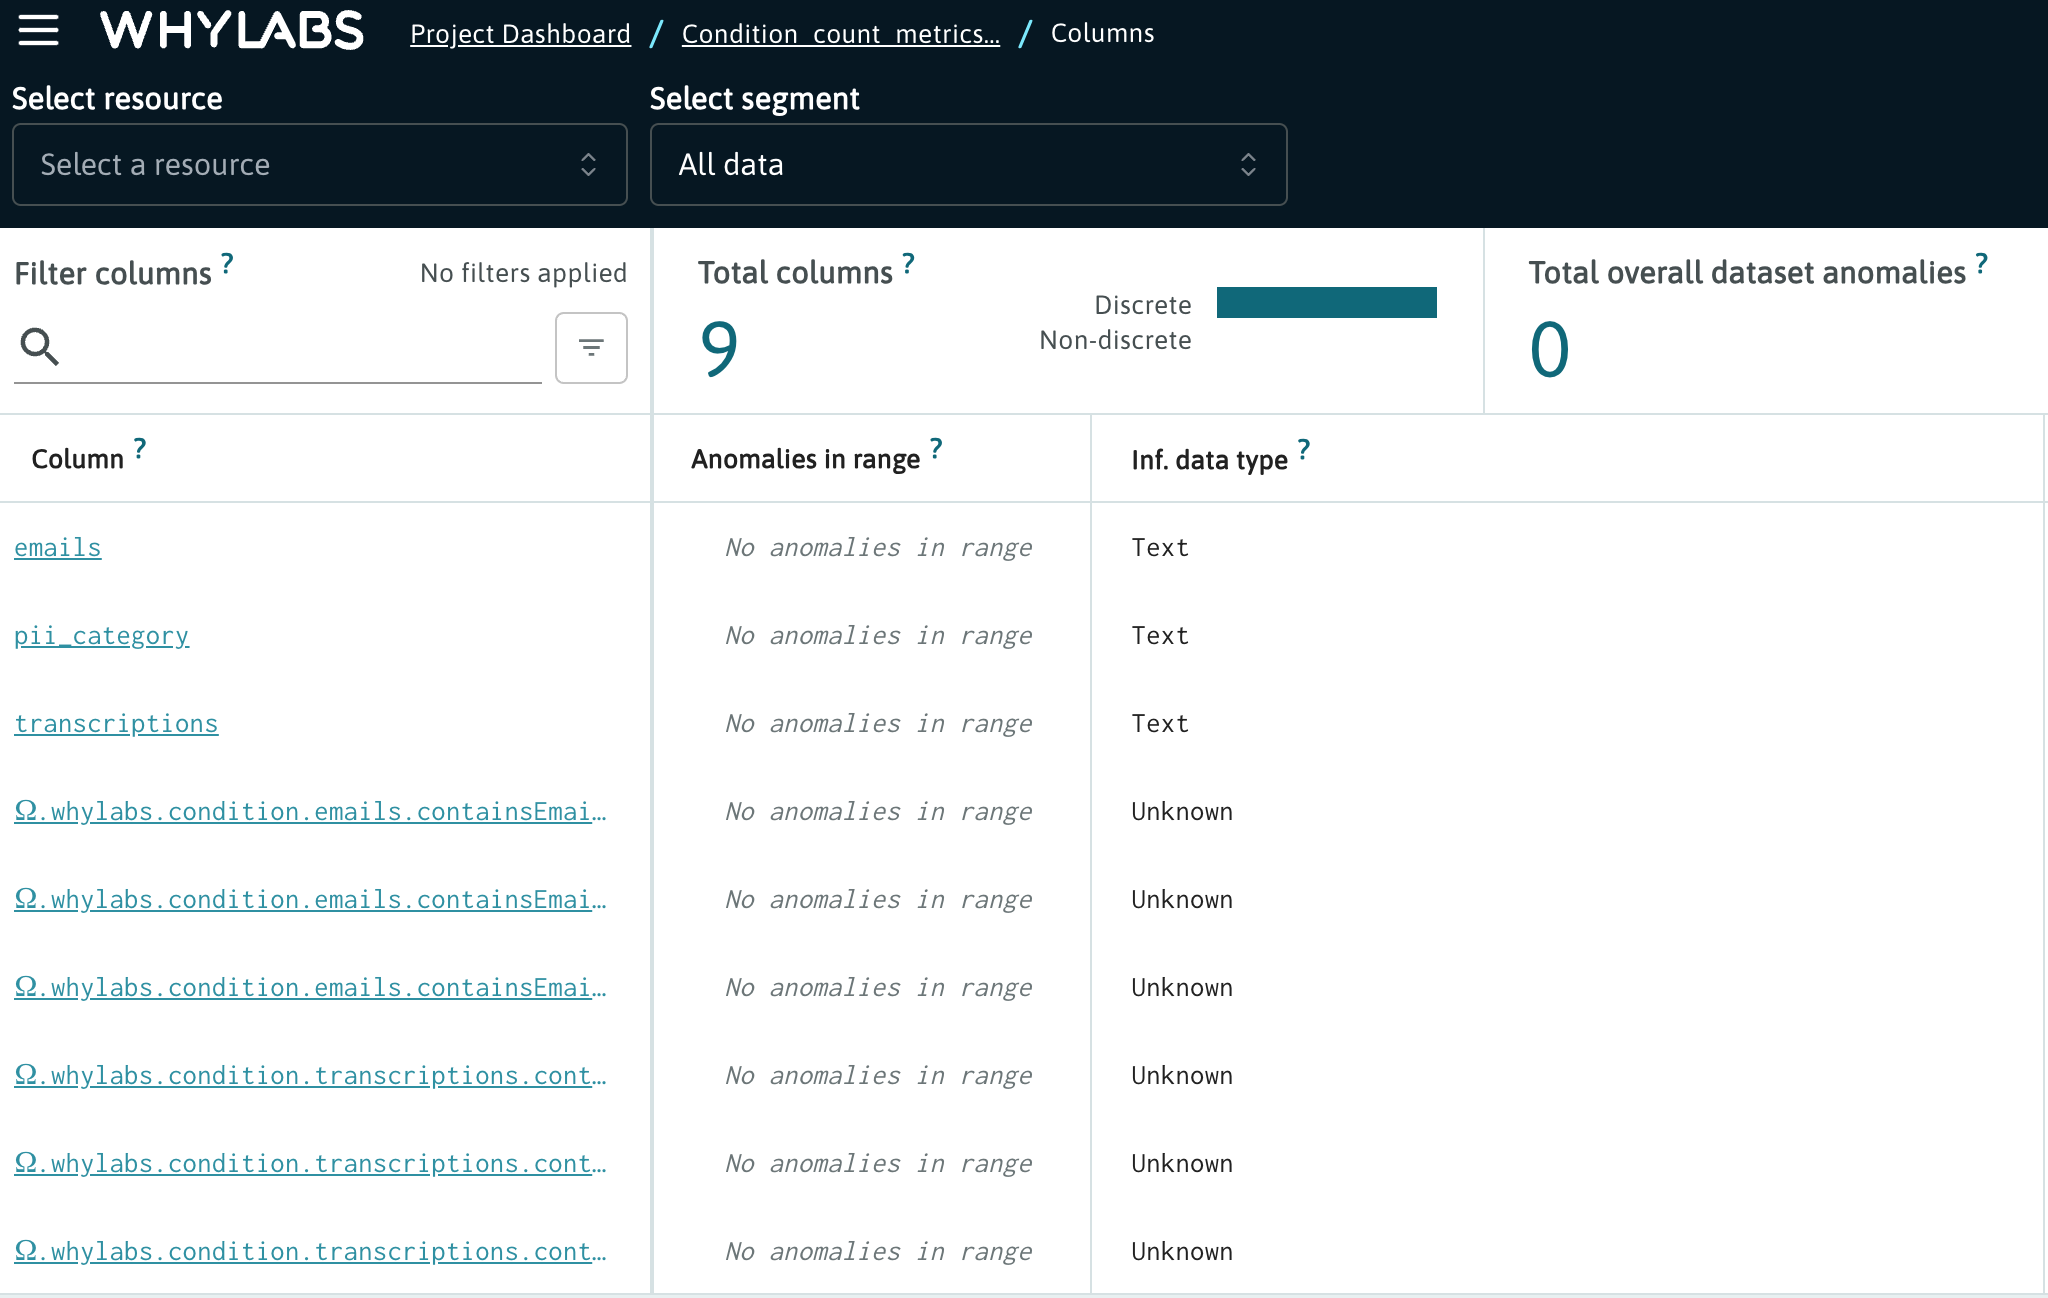